In [7]:
import pandas as pd
import numpy as np
import os
import glob
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn
import sklearn
from shapely.geometry import Point, Polygon, box
import scipy

seaborn.set()
# numpy pandas shapely geopandas rasterio
cwd_path = os.getcwd()
usa_quake_path = cwd_path + "\\earthquake_contiguous_usa_12batch\\"
eu_quake_path = cwd_path + "\\Earthquake_2016_2018_all_eu\\"

In [8]:
# CSVs are appended to an array/list as DataFames.
# Done for both US and EU data
us_df = []
eu_df = []
for us in glob.glob(usa_quake_path+"*.csv"):
    us_df.append(pd.read_csv(us))


for eu in glob.glob(eu_quake_path+"*.csv"):
    eu_df.append(pd.read_csv(eu))

In [9]:
# Batch allocation 
us_batch = []
for y in range(10):
    batch = pd.concat((us_df[y+0], us_df[y+1], us_df[y+2]),ignore_index=True)
    us_batch.append(batch)

In [10]:
# Geo batch allocation
geo_us_batch = []
for y in range(10):
    geo_us_batch.append(gpd.GeoDataFrame(us_batch[y]))

In [11]:
#takes in geodataframes
def find_bounds(gdfs):
    lat_min_max_table =[];
    for x in geo_df:
        xmin, ymin, xmax, ymax= x.total_bounds
        lat_min_max_table.append([xmin,ymin,xmax,ymax])
    lat_min_max_df = pd.DataFrame(lat_min_max_table, columns =['xmin', 'ymin', 'xmax', 'ymax'])
    long_xmin = lat_min_max_df.xmin.min()
    long_xmax = lat_min_max_df.xmax.max()
    
    lat_ymin = lat_min_max_df.ymin.min()
    lat_ymax = lat_min_max_df.ymax.max()
    return long_xmin, lat_ymin, long_xmax, lat_ymax


In [17]:
# converts batch dataframes into batches of geodataframes

def geo_frames(dfs):
    geo_df = []
    for a in dfs:
        current_geo_df = gpd.GeoDataFrame(a,
                                          crs='epsg:4326',geometry=[Point(xy) for xy in zip(a.longitude, a.latitude)])
        # here is the filtering
        current_geo_df = current_geo_df[current_geo_df.mag >= 3]
        current_geo_df = current_geo_df[current_geo_df.depth <= 100]
        
        current_geo_df = current_geo_df.reset_index(drop=True)
        geo_df.append(current_geo_df)
    return geo_df

In [12]:
# sets the grid overall bounds and cell bounds for each batch. 
# these bounds depend on the overal bounds, say |max(longitude) - min(longitude)| / n_cells

def set_grid(gdfs):
    cell_list = []
    xmin, ymin, xmax, ymax = find_bounds(gdfs)
    for i in gdfs:
        #xmin, ymin, xmax, ymax= i.total_bounds
        n_cells=45
        cell_size = (xmax-xmin)/n_cells
        
        grid_cells = []
        for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
            for y0 in np.arange(ymin, ymax+cell_size, cell_size):
                # bounds
                x1 = x0-cell_size
                y1 = y0+cell_size
                grid_cells.append( box(x0, y0, x1, y1)  )
        cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],crs='epsg:4326')
        cell_list.append(cell)
    return cell_list

In [13]:
# for each batch, the number of events is counted for each cell in that batch
# returns an a list/array, one for each batch
# each subarray gives the number of events per each cell

def event_count(grid,gdf):
    if len(grid) != len(gdf):
        return print("length mismatch")
    count_list = []
    for x in range(len(grid)):
        min_max_table=[] # is an array of cells bounds for each cell
        geo_table=[]     # is an array of long and lat from batch(es)
        counter=[]       # is an array that holds occurences of quakes per cell

        # gives the min and max longs and lats for given cells (aka the bounds of the cell)
        for i in range(len(grid[x])):
            xmin, ymin, xmax, ymax= grid[x].loc[i].geometry.bounds
            min_max_table.append([xmin,ymin,xmax,ymax])
        # appends the points from the geodataframe 'Geometry.Point'
        for j in range(len(gdf[x])):
            geo_table.append([gdf[x].geometry.x[j], gdf[x].geometry.y[j]])
        for i in range(len(grid[x])):
            counter.append(0)
            for j in range(len(gdf[x])):
                if ((geo_table[j][0] < min_max_table[i][2]) & (geo_table[j][0] > min_max_table[i][0]) & (geo_table[j][1] < min_max_table[i][3]) & (geo_table[j][1] > min_max_table[i][1])):
                    counter[i] +=1
        count_list.append(counter)
    return count_list

In [14]:
# gets the grid with the hotspots/events in it and also returns the base grid used in analysis

def get_frame_ready(count_list,grid_list):
    hotspot_list = []
    geo_df_list = []
    for x in range(len(grid_list)):
        working_df = pd.DataFrame(grid_list[x].loc[:].geometry.bounds)
        working_df['counter'] = count_list[x]
        geometry_for_df = [box(x1,y1,x2,y2) for x1,y1,x2,y2
                           in zip(working_df.minx,working_df.miny, working_df.maxx,working_df.maxy)]
        bounds_df = gpd.GeoDataFrame(working_df.drop(['minx','miny','maxx','maxy'], axis=1), geometry=geometry_for_df)
        
        geo_df_list.append(bounds_df)
        hotspot_df = bounds_df.copy()
        hotspot_df[hotspot_df.counter == 0] = np.nan
        hotspot_list.append(hotspot_df)

    return hotspot_list, geo_df_list

In [15]:
# Plots the USA map, the hotspots, the grid itself, and the scatter points 
# takes in the long,lat geodataframe, the base grid used, the hotspots, the "density" we want

def poimagic(geo_df,base_grid, hotspot_grid,density):
    long_min, lat_min, long_max, lat_max = find_bounds(geo_df)
    plt.rcParams["figure.figsize"] = [20, 20]
    states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    for x in range(len(geo_df)):
        state_plot = states.plot()
        state_plot.set_xlim(long_min-5,long_max+5)
        state_plot.set_ylim(lat_min-5,lat_max+5)
        
        hotspot_grid[x].plot(ax = state_plot, column="counter",edgecolor="black",
                             cmap="viridis",vmax = density, alpha = 0.7)
        base_grid[x].plot(ax = state_plot, facecolor="None",edgecolor="black")
        plt.scatter( geo_df[x].longitude, geo_df[x].latitude,c="red",marker='.')

In [18]:
# US DATA
geo_df = geo_frames(us_batch)
grid_list = set_grid(geo_df)

In [19]:
count_list = event_count(grid_list,geo_df)
hotspot_grid, base_grid = get_frame_ready(count_list,grid_list)

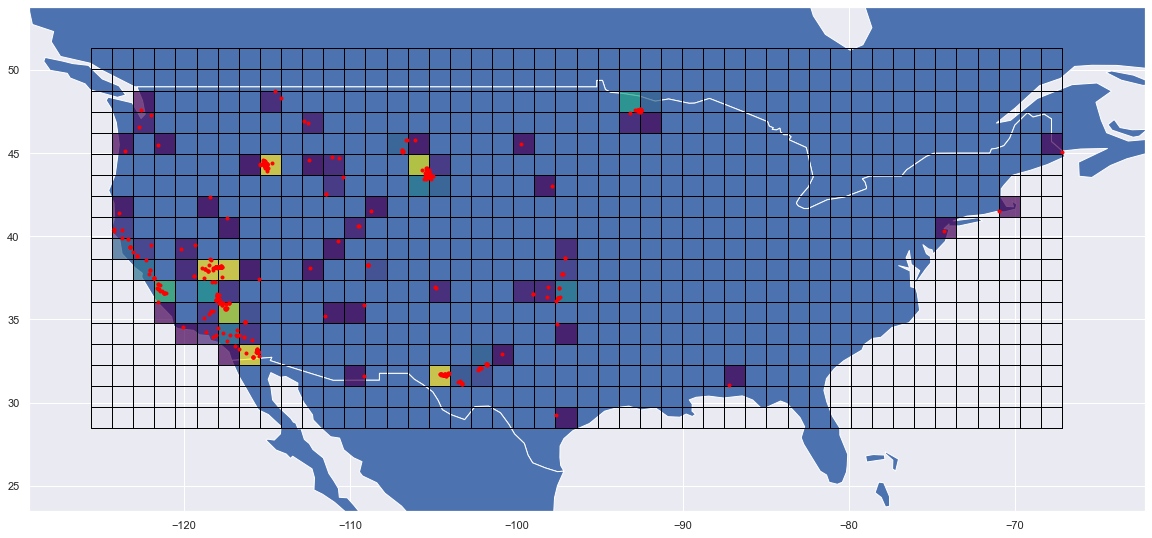

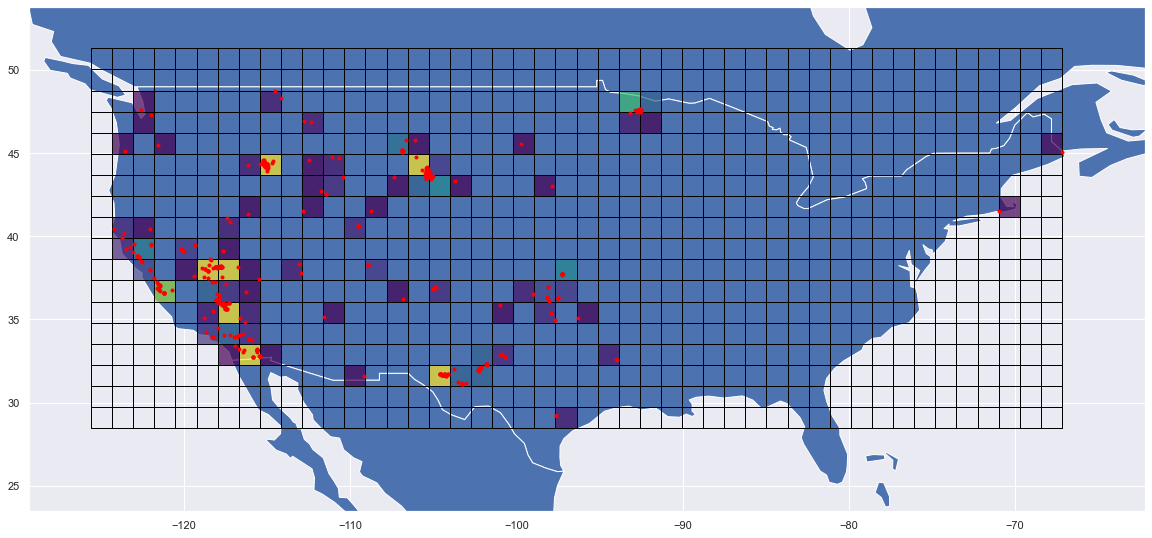

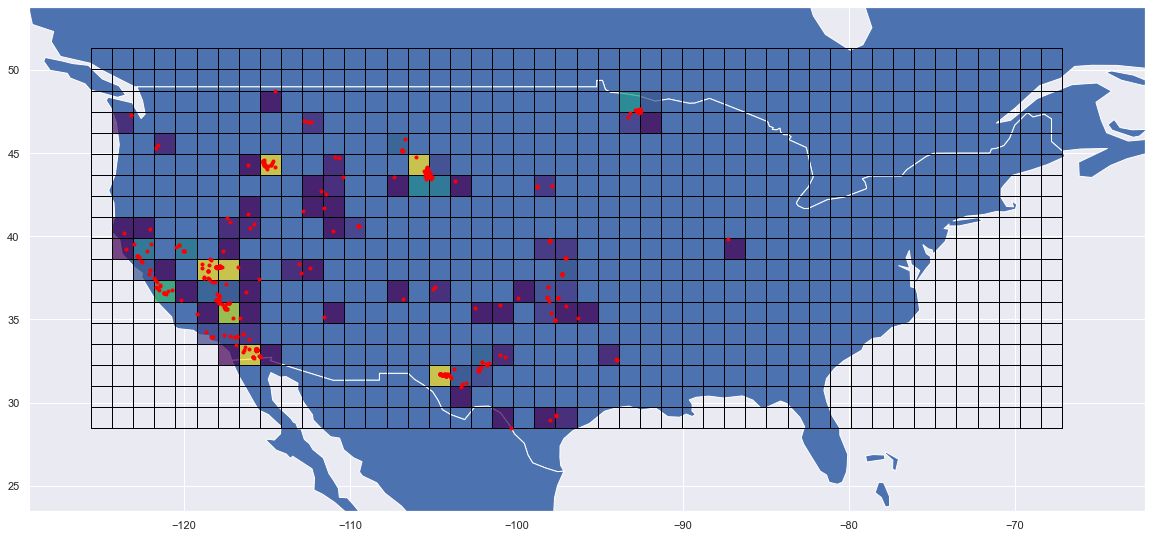

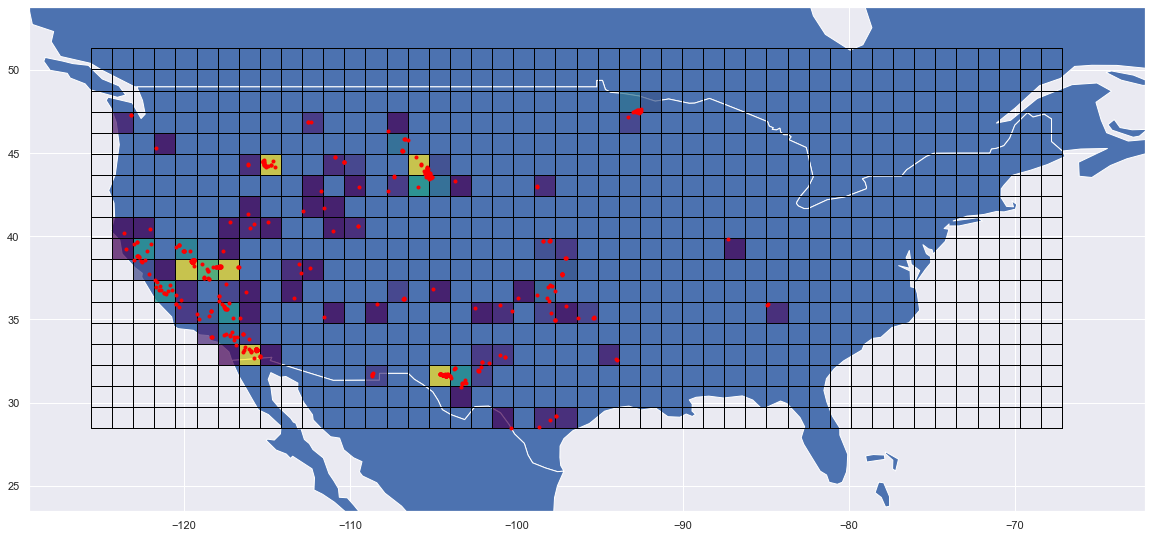

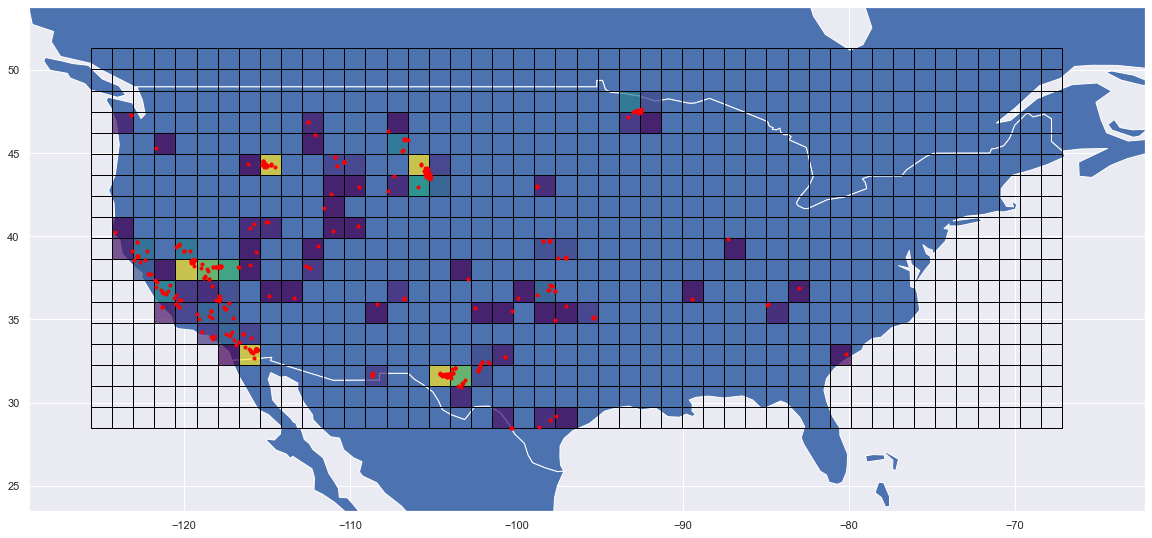

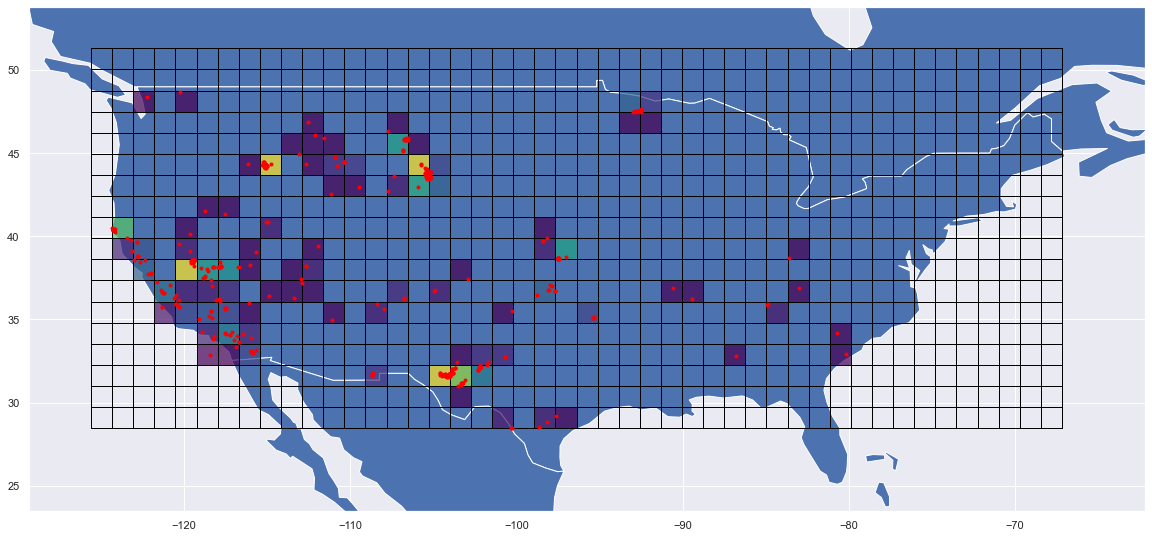

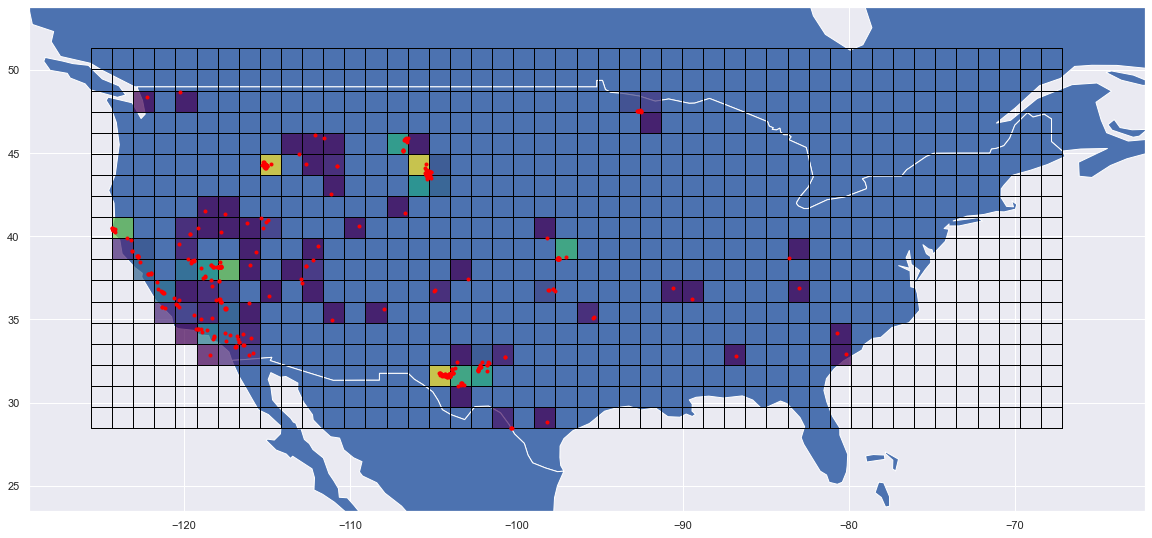

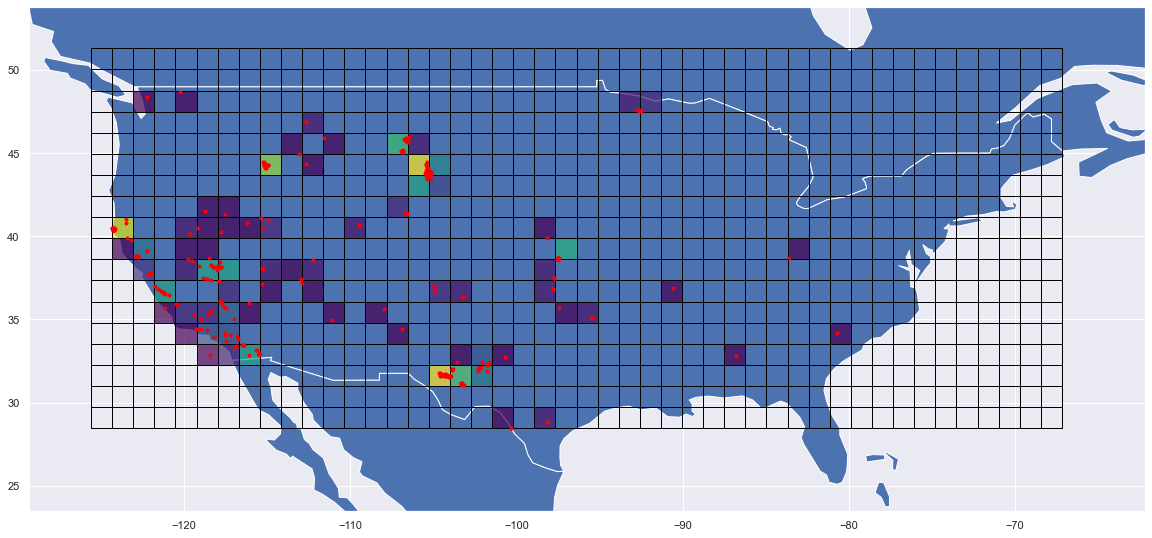

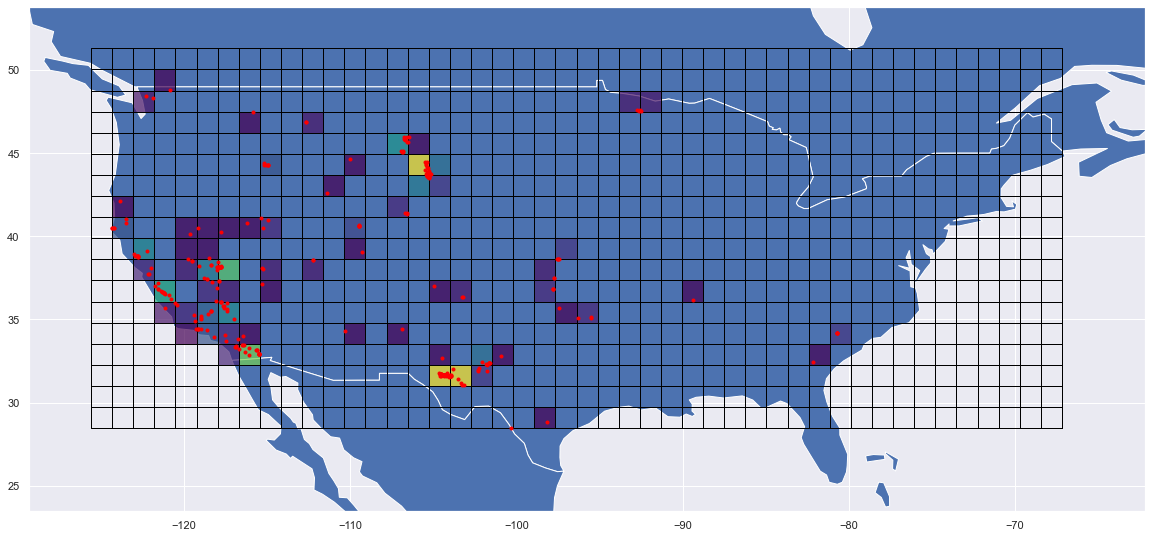

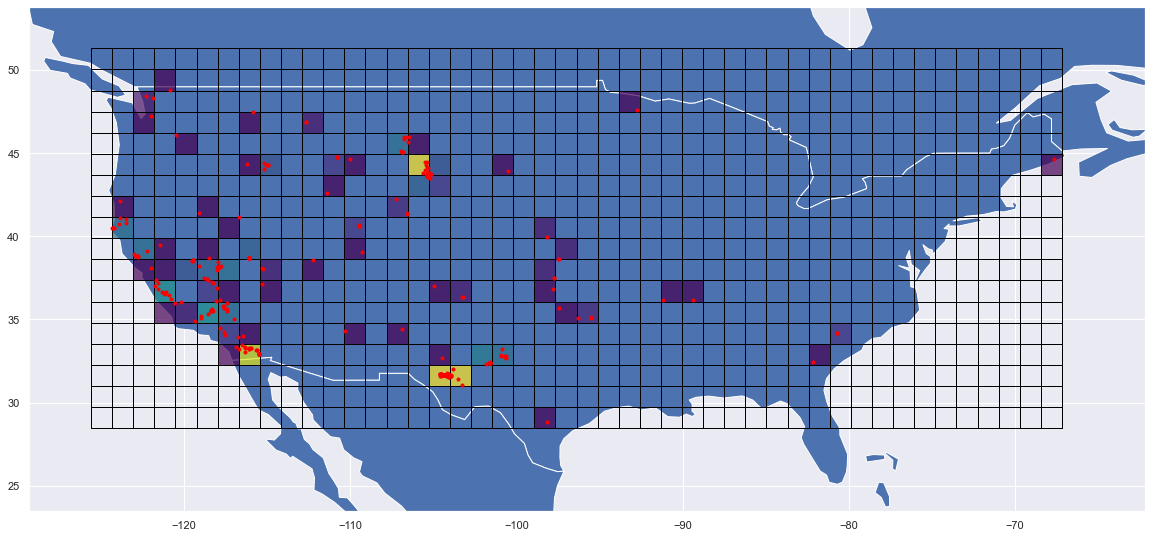

In [21]:
poimagic(geo_df,base_grid,hotspot_grid,20)

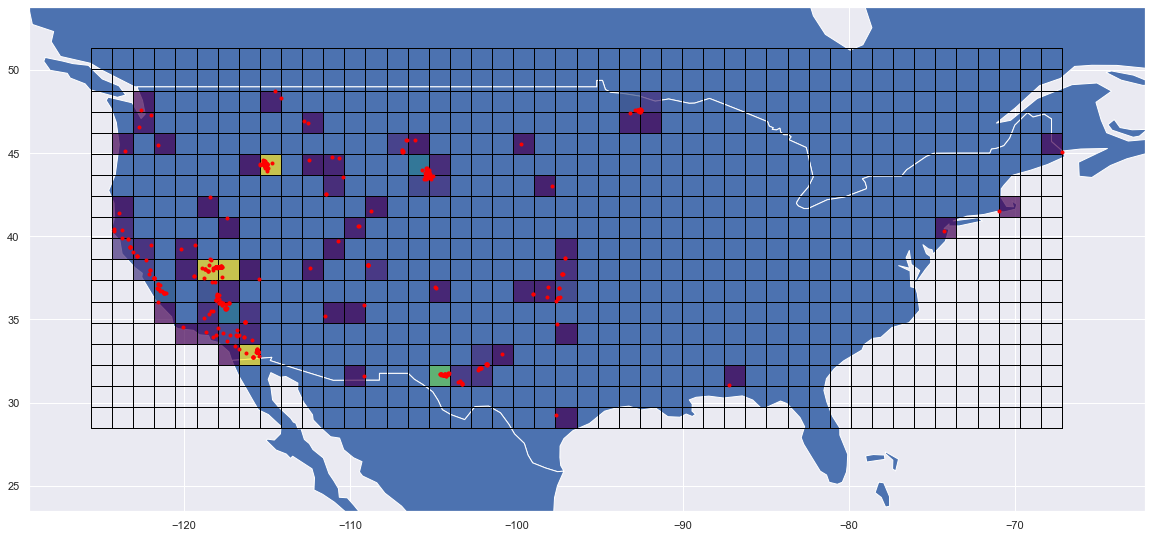

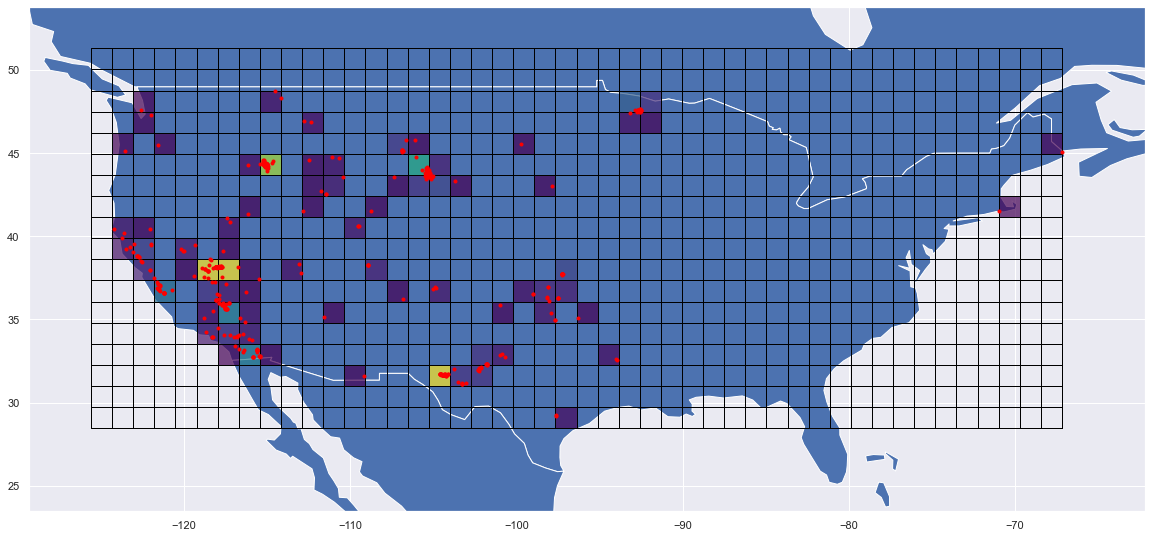

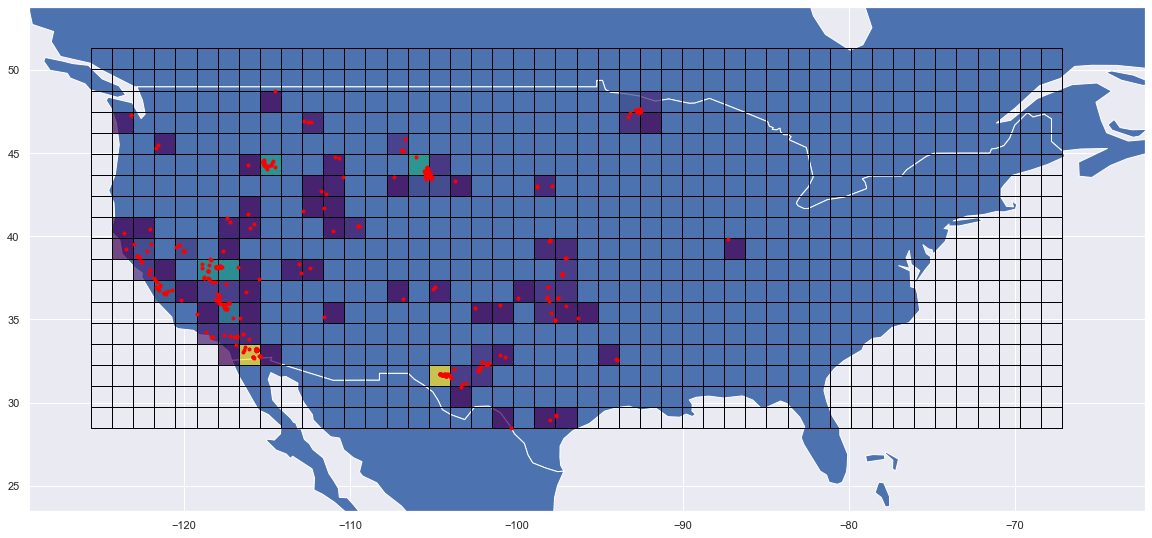

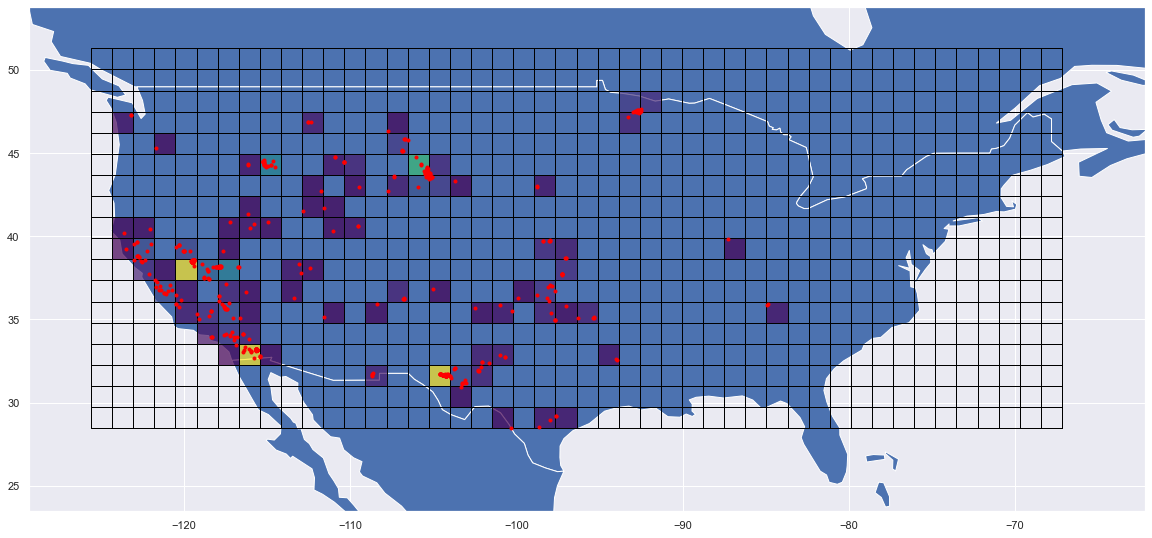

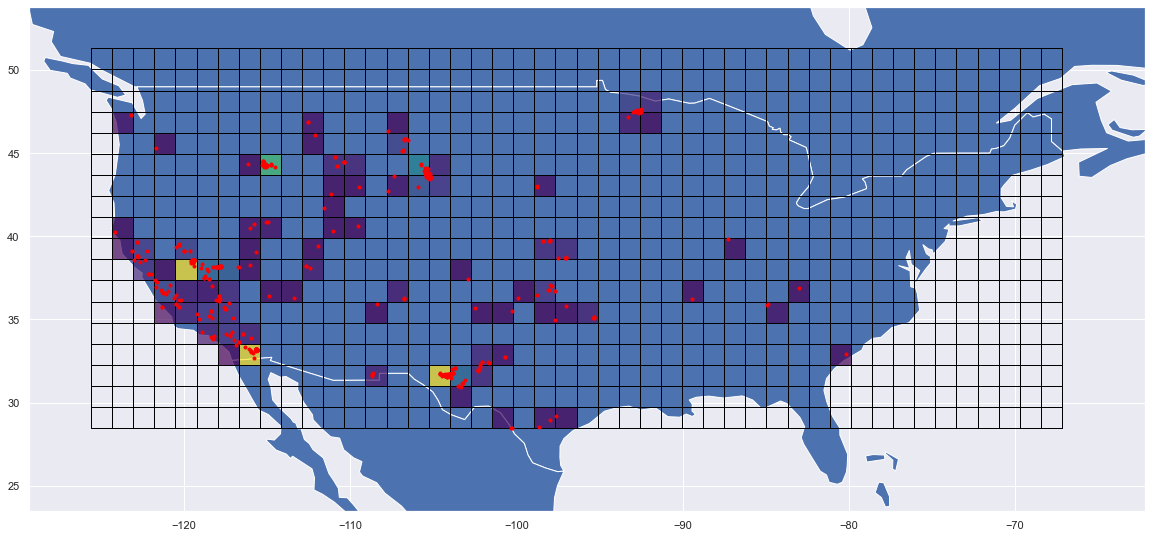

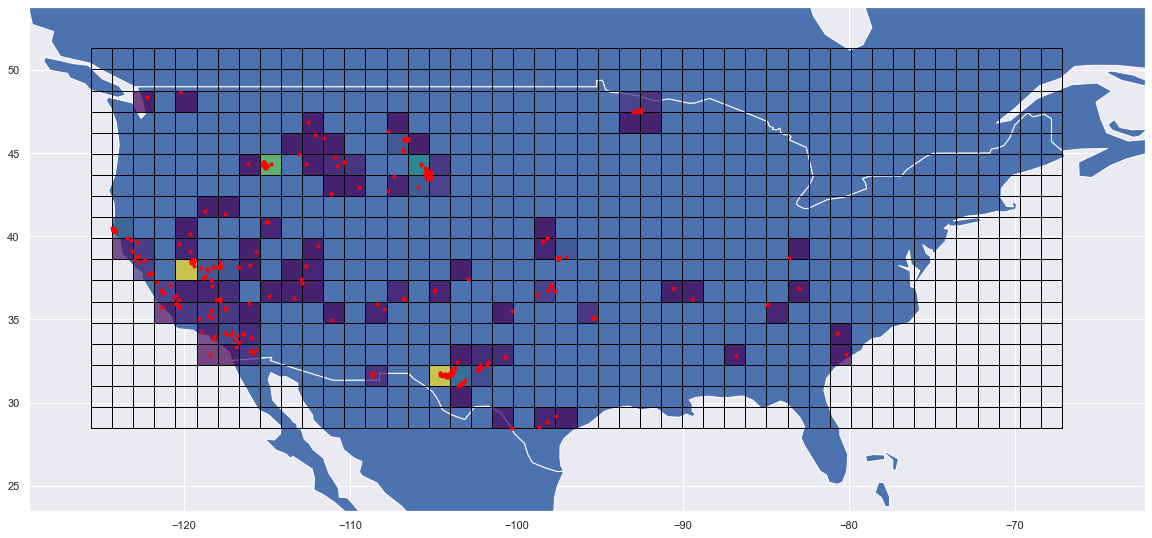

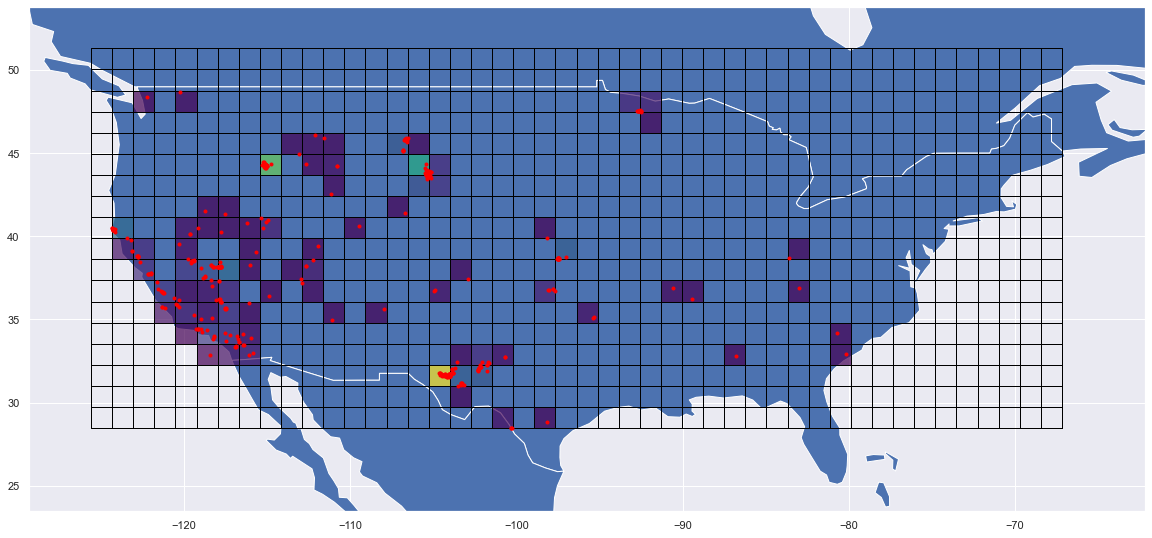

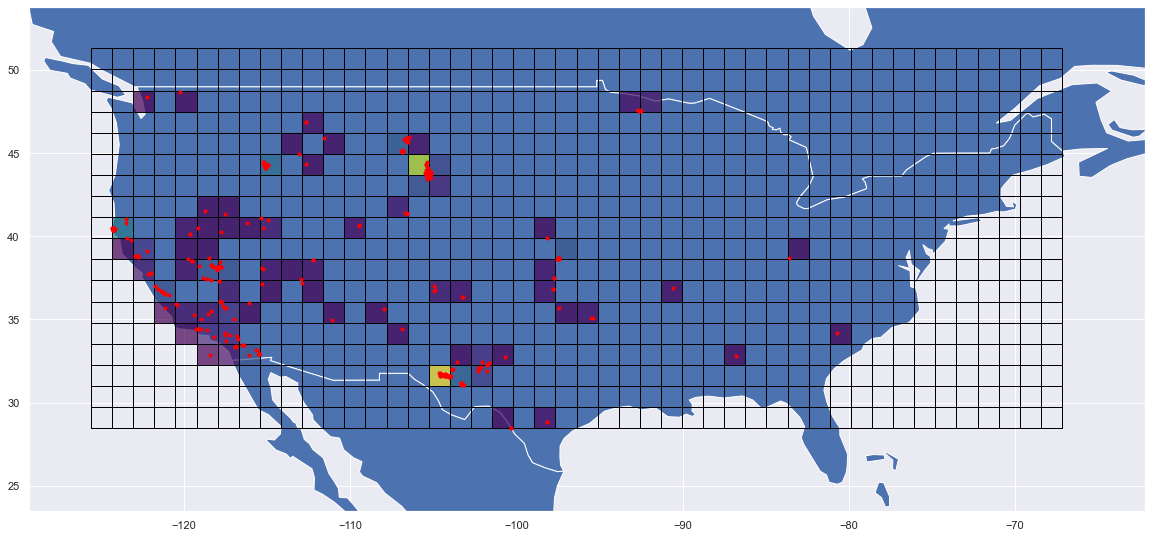

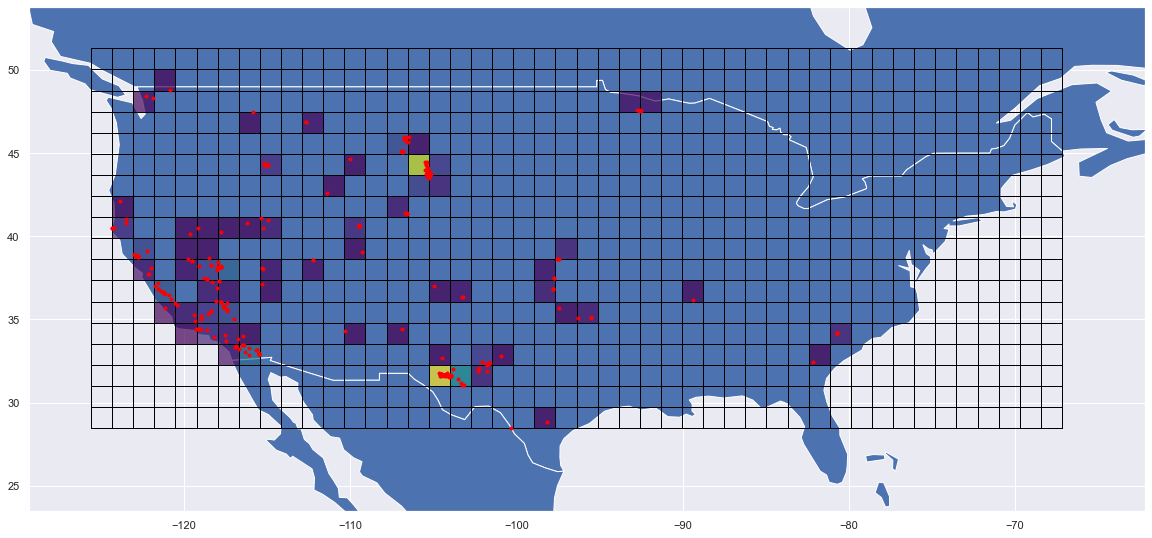

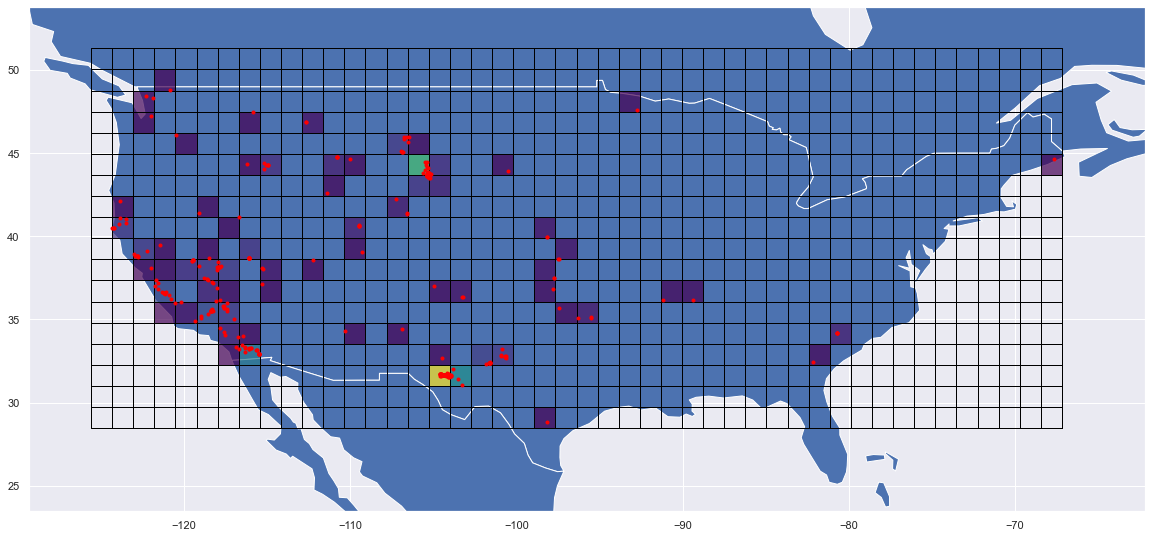

In [22]:
poimagic(geo_df,base_grid,hotspot_grid,45)